In [133]:
#All  the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten, Dropout

In [134]:
#import dataset and combine the image
import zipfile
with zipfile.ZipFile('Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')
# Specify the folder path where the images are located
folder_path = './patch_images/'

# Use glob to get a list of image file paths
image_paths = glob.glob(folder_path + '/*.png')  # Change the extension as per your image file types
df_paths = pd.DataFrame({'Image_Path': image_paths})

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


df_paths['ImageName'] = df_paths['Image_Path'].apply(lambda x: os.path.basename(x))
data_merged_main  = pd.merge(main_data,df_paths, on='ImageName',how='inner')
data_merged_extra = pd.merge(extra_data,df_paths, on='ImageName',how='inner')

data_merged_main.head()


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image_Path
0,22405,1,22405.png,fibroblast,0,0,./patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,./patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,./patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,./patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,./patch_images/22409.png


In [135]:
data_merged_extra.head()

,InstanceID,patientID,ImageName,isCancerous,Image_Path
0,12681,61,12681.png,0,./patch_images/12681.png
1,12682,61,12682.png,0,./patch_images/12682.png
2,12683,61,12683.png,0,./patch_images/12683.png
3,12684,61,12684.png,0,./patch_images/12684.png
4,12685,61,12685.png,0,./patch_images/12685.png


In [136]:
#split the data into 60 20 20
train_data, test_data = train_test_split(data_merged_main , test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data , test_size=0.25, random_state=0)

# train_data, test_data = train_test_split(train_data2, test_size=0.2, random_state=0)
# train_data, val_data = train_test_split(train_data2, test_size=0.25, random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [179]:
#set the parameters
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4
batch_size = 32

<h1>Base Model <h1>

In [165]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_51 (Flatten)        (None, 2187)              0         
                                                                 
 dense_110 (Dense)           (None, 256)               560128    
                                                                 
 dense_111 (Dense)           (None, 256)               65792     
                                                                 
 dense_112 (Dense)           (None, 4)                 1028      
                                                                 
Total params: 626,948
Trainable params: 626,948
Non-trainable params: 0
_________________________________________________________________


In [166]:
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)
test_data['cellType'] = test_data['cellType'].astype(str)

In [167]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [168]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/var/folders/6y/3ldd75pj46v0c4qyh730qx400000gn/T/ipykernel_7956/2779164914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 17:49:31.266076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 17:49:37.122602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [169]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)

2023-05-16 17:55:14.263738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Train Loss: 0.7812758088111877
Train Accuracy: 0.7121441960334778


2023-05-16 17:55:18.314660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Loss: 0.7748677730560303
Validation Accuracy: 0.7109651565551758


In [170]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

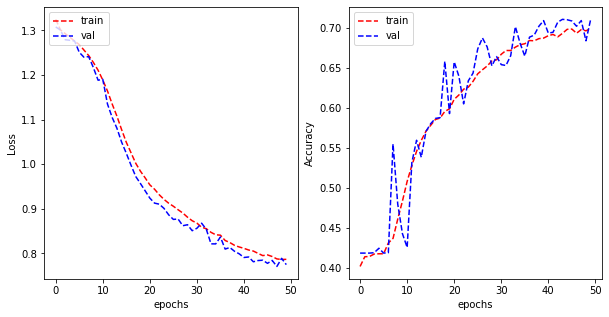

In [171]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [172]:
#test data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')



test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=1,
        class_mode='categorical')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Found 1980 validated image filenames belonging to 4 classes.


2023-05-16 17:55:31.523776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.81099534034729
Test Accuracy: 0.6939393877983093


TypeError: Invalid shape (32, 27, 27, 3) for image data

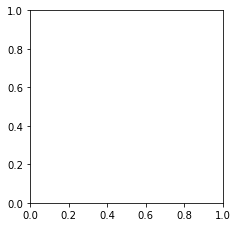

In [178]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

<H1> Hyper tunning the parameters to  reduce the loss value <h1>

In [150]:
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)
test_data['cellType'] = test_data['cellType'].astype(str)

In [151]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the model architecture
model_2 = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_2.summary()
#learning rate  set at 0.001
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)


#tunning the data generation futhermore
train_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)
val_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)

test_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)
batch_size = 1

train_generator_model_2 = train_dataGen_Model_2.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_model_2 = train_dataGen_Model_2.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator_model_2 = test_dataGen_Model_2.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

epochs = 25 #setting  to  50 for testing
history_1 = model_2.fit(
    train_generator_model_2,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=validation_generator_model_2,
    validation_steps=len(val_data) // batch_size,
    # callbacks=[early_stopping, reduce_lr]
)




Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_165 (Conv2D)         (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d_141 (MaxPooli  (None, 12, 12, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_166 (Conv2D)         (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_142 (MaxPooli  (None, 5, 5, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_49 (Flatten)        (None, 1600)              0         
                                                                 
 dense_106 (Dense)           (None, 256)             

2023-05-16 15:57:50.380645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/opt/miniconda3/envs/minimal_ds/lib/python3.9/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5937/5937 [==============================] - ETA: 0s - loss: 1.0955 - categorical_accuracy: 0.5501

2023-05-16 15:58:15.208057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5937/5937 [==============================] - 28s 4ms/step - loss: 1.0955 - categorical_accuracy: 0.5501 - val_loss: 0.9018 - val_categorical_accuracy: 0.6200
Epoch 2/25
5937/5937 [==============================] - 25s 4ms/step - loss: 0.8994 - categorical_accuracy: 0.6456 - val_loss: 0.8153 - val_categorical_accuracy: 0.6953
Epoch 3/25
5937/5937 [==============================] - 29s 5ms/step - loss: 0.8658 - categorical_accuracy: 0.6567 - val_loss: 0.8459 - val_categorical_accuracy: 0.6695
Epoch 4/25
5937/5937 [==============================] - 32s 5ms/step - loss: 0.8315 - categorical_accuracy: 0.6739 - val_loss: 0.7859 - val_categorical_accuracy: 0.7009
Epoch 5/25
5937/5937 [==============================] - 26s 4ms/step - loss: 0.8084 - categorical_accuracy: 0.6778 - val_loss: 0.7379 - val_categorical_accuracy: 0.7140
Epoch 6/25
5937/5937 [==============================] - 24s 4ms/step - loss: 0.7887 - categorical_accuracy: 0.6852 - val_loss: 0.7402 - val_categorical_accuracy: 0.70

In [152]:
train_loss, train_accuracy = model_2.evaluate(train_generator_model_2, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_2.evaluate(validation_generator_model_2, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)


test_loss, test_accuracy = model_2.evaluate(test_generator_model_2, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

2023-05-16 16:11:19.036280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Train Loss: 0.6690857410430908
Train Accuracy: 0.7411150336265564


2023-05-16 16:11:28.785838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Loss: 0.647203266620636
Validation Accuracy: 0.7539161443710327


2023-05-16 16:11:31.867304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.6672702431678772
Test Accuracy: 0.7338383793830872


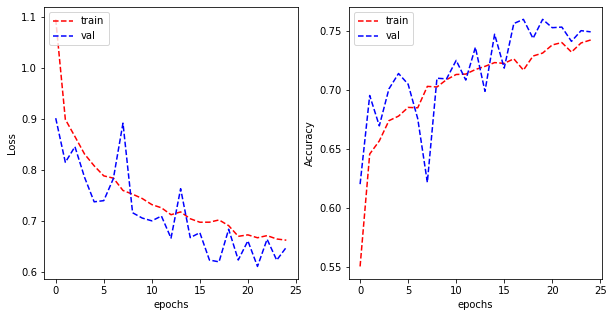

In [153]:
plot_learning_curve(history_1.history['loss'], history_1.history['val_loss'], 
                    history_1.history['categorical_accuracy'], history_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

<h1>VGG


In [154]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4),
])

In [155]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [156]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

/var/folders/6y/3ldd75pj46v0c4qyh730qx400000gn/T/ipykernel_7956/1457444843.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)
2023-05-16 16:14:30.499760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 16:14:42.987594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [160]:
#using the vvg1 model with the  hyper tuned  generators
history_VGG_1_X_genTuned = model_VGG_1.fit_generator(train_generator_model_2, validation_data = validation_generator_model_2, epochs=25, verbose=0)

/var/folders/6y/3ldd75pj46v0c4qyh730qx400000gn/T/ipykernel_7956/2623025198.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_1_X_genTuned = model_VGG_1.fit_generator(train_generator_model_2, validation_data = validation_generator_model_2, epochs=25, verbose=0)
2023-05-16 16:25:15.505367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 16:26:06.602098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{

In [157]:
train_loss, train_accuracy = model_VGG_1.evaluate(train_generator, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_VGG_1.evaluate(validation_generator, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)


test_loss, test_accuracy = model_VGG_1.evaluate(test_generator, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

2023-05-16 16:21:13.186997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Train Loss: 0.012606368400156498
Train Accuracy: 0.9978103637695312


2023-05-16 16:21:15.901987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Loss: 1.4689767360687256
Validation Accuracy: 0.7559373378753662


2023-05-16 16:21:16.721709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 1.5829944610595703
Test Accuracy: 0.7383838295936584


In [163]:
#print  for  the hypertuned
train_loss, train_accuracy = model_VGG_1.evaluate(train_generator_model_2, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_VGG_1.evaluate(validation_generator_model_2, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)


2023-05-16 16:49:29.525099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Train Loss: 0.778903067111969
Train Accuracy: 0.6934478878974915


2023-05-16 16:49:43.585558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Loss: 0.7480974197387695
Validation Accuracy: 0.7165234684944153


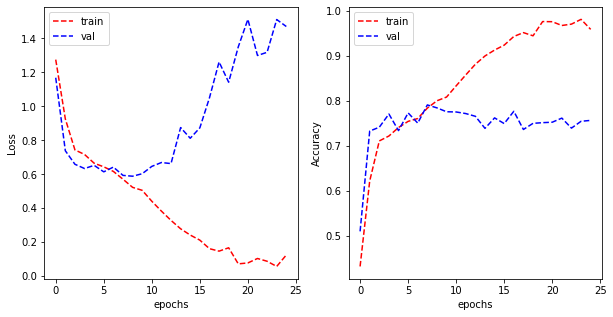

In [158]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

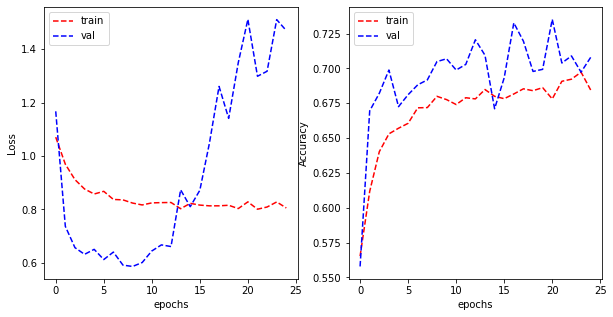

In [162]:
plot_learning_curve(history_VGG_1_X_genTuned.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1_X_genTuned.history['categorical_accuracy'], history_VGG_1_X_genTuned.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

<h1>VVG2


In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/var/folders/6y/3ldd75pj46v0c4qyh730qx400000gn/T/ipykernel_7956/825115039.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)
2023-05-16 06:50:28.820851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 06:50:40.579972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


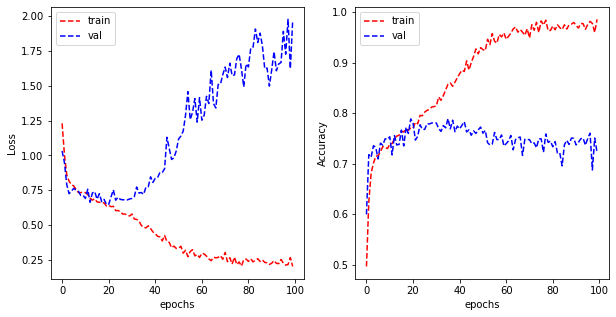

In [ ]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
train_loss, train_accuracy = model_VGG_2.evaluate(train_generator, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_VGG_2.evaluate(validation_generator, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)


test_loss, test_accuracy = model_VGG_2.evaluate(test_generator, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

2023-05-16 07:11:24.820657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Train Loss: 0.1894916296005249
Train Accuracy: 0.9902307391166687


2023-05-16 07:11:27.721842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Loss: 1.9691627025604248
Validation Accuracy: 0.7225871682167053


2023-05-16 07:11:28.504064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 2.0437393188476562
Test Accuracy: 0.7181817889213562
